In [2]:
import pandas as pd
from plotly.offline import iplot
import plotly.graph_objs as go
import numpy as np
from sklearn import metrics
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial
from itertools import repeat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Activation
import keras.backend as K
import os
from keras import metrics

Using TensorFlow backend.


In [3]:
# returns dataframe
# params: full -> True = full dataset, False = first file

def grab_data(full, cols, path):
    if full:
        return pd.concat([pd.read_csv(path+file, names=cols, index_col=False) for file in os.listdir(path)])
    else:
        for file in os.listdir(path):
            if "10_1_" not in file: continue
            return pd.read_csv(path+file, names=cols, index_col=False)

In [87]:
# import data

nBodies = 3
workDir = "/Users/brandonmanley/Documents/nBody/data"
dataPath = "/Users/brandonmanley/Documents/nBody/data/brutusSim/"+str(nBodies)+"body/"

dataCols = ["file", "eventID"]
perParticleColumnsInput = ["m", "x", "y", "dx", "dy"]
perParticleColumnsOutput = ["xf", "yf", "dxf", "dyf"]

for col in perParticleColumnsInput:
    for i in range(nBodies):
        dataCols.append(col+str(i+1))
dataCols.append("t")
for col in perParticleColumnsOutput:
    for i in range(nBodies):
        dataCols.append(col+str(i+1))
        
df = grab_data(True, dataCols, dataPath)

with pd.option_context('mode.use_inf_as_null', True):
    df = df.dropna(axis=1)
    df = df.dropna(axis=0)
    
dfShuffle = shuffle(df,random_state=42)
df.head()

,file,eventID,m1,m2,m3,x1,x2,x3,y1,y2,...,xf3,yf1,yf2,yf3,dxf1,dxf2,dxf3,dyf1,dyf2,dyf3
0,1,10001,5.702832,58.638287,54.862347,-0.429122,-3.287465,2.112128,-8.012798,9.542259,...,2.111637,-8.009622,9.541494,3.759572,0.321621,-0.577427,-0.127013,0.814151,-0.197060,0.279734
1,1,10002,5.702832,58.638287,54.862347,-0.429122,-3.287465,2.112128,-8.012798,9.542259,...,2.111136,-8.006437,9.540719,3.760669,0.321816,-0.575079,-0.129543,0.816311,-0.199630,0.282257
2,1,10003,5.702832,58.638287,54.862347,-0.429122,-3.287465,2.112128,-8.012798,9.542259,...,2.110625,-8.003244,9.539934,3.761777,0.322011,-0.572729,-0.132075,0.818473,-0.202200,0.284779
3,1,10004,5.702832,58.638287,54.862347,-0.429122,-3.287465,2.112128,-8.012798,9.542259,...,2.110104,-8.000043,9.539140,3.762894,0.322205,-0.570379,-0.134607,0.820635,-0.204770,0.287301
4,1,10005,5.702832,58.638287,54.862347,-0.429122,-3.287465,2.112128,-8.012798,9.542259,...,2.109573,-7.996833,9.538335,3.764021,0.322400,-0.568027,-0.137141,0.822798,-0.207339,0.289821


In [92]:
# FIXME: 
#     -add conservation laws: E, p, CM

def modified_mse(y_true,y_pred):
    y_true_slice = y_true[:, (nBodies*5 + 1):] 
    mse = K.mean(K.square(y_pred - y_true_slice), axis=-1)
    ploss = momentum_loss(y_true, y_pred)
#     cmloss = cm_loss(y_true, y_pred)
    
    return mse

def modified_acc(y_true, y_pred):
    y_true_slice = y_true[:, (nBodies*5 + 1):] 
    return metrics.mae(y_true_slice, y_pred)


def momentum_loss(y_true, y_pred): # given the true/pred tensors, returns momentum loss
    masses = y_true[:,:nBodies]
    init_vel_x = y_true[:, 3*nBodies:4*nBodies]
    init_vel_y = y_true[:, 4*nBodies:5*nBodies]
    pred_vel_x = y_pred[:, 2*nBodies:3*nBodies]
    pred_vel_y = y_pred[:, 3*nBodies:]
    
    ipx, ipy, px, py = 0,0,0,0
    for n in range(nBodies):
        ipx += masses[:, n]*init_vel_x[:, n]
        ipy += masses[:, n]*init_vel_y[:, n]
        px += masses[:, n]*pred_vel_x[:, n]
        py += masses[:, n]*pred_vel_y[:, n]
        
    p = ((ipx - px)**2 + (ipy - py)**2)**0.5
    return p


def cm_loss(y_true, y_pred): # given the true/pred tensors, returns momentum loss
    masses = y_true[:,:nBodies]
    init_pos_x = y_true[:, nBodies:2*nBodies]
    init_pos_y = y_true[:, 2*nBodies:3*nBodies]
    pred_pos_x = y_pred[:, :nBodies]
    pred_pos_y = y_pred[:, nBodies:2*nBodies]
    
    icx, icy, cx, cy = 0,0,0,0
    mass_term = 0
    
    for n in range(nBodies):
        mass_term += masses[:, n] 
    
    for n in range(nBodies):
        icx += (masses[:, n]*init_pos_x[:, n])/mass_term
        icy += (masses[:, n]*init_pos_y[:, n])/mass_term
        cx += (masses[:, n]*pred_pos_x[:, n])/mass_term
        cy += (masses[:, n]*pred_pos_y[:, n])/mass_term
        
    cm = ((icx - cx)**2 + (icy - cy)**2)**0.5
    return cm


def modified_mae(y_true, y_pred):
    y_true_slice = y_true[:, (nBodies*5 + 1):] 
    return metrics.mae(y_true_slice, y_pred)

In [88]:
# INPUT: want mass, x/y pos, dx/dy for n bodies -> total input is n*5 + 1 (time)
# OUTPUT: want x/y, dx/dy -> total input is n*4

i_col, o_col = [], []
colNames = ["m", "x", "y", "dx", "dy"]

for col in colNames:
    for n in range(1, nBodies+1):
        i_col.append(col+str(n))
        if col != "m":
            o_col.append(col+"f"+str(n))
i_col.append("t")
    
X1 = df.as_matrix(columns=i_col)
y1 = df.as_matrix(columns=o_col+i_col)

X_train,X_test,y_train,y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



(5152127, 16) (5152127, 28)
(1288032, 16) (1288032, 28)


In [7]:
for i in y_train[1]:
    print(i)

-7.555949469459996
0.4455705974099731
-8.04207362608623
1.2966407776739208
7.106293796329801
1.1137062883252749
9.53715482215116
-0.1516846628648441
-6.926845133213357
9.25166446403884
-1.2919992174177428
-5.202310845080119
54.09194779714071
90.90837725517487
73.69270665456658
-7.120242
0.8664379999999999
-8.435949
6.00183
9.980988
-5.865754
0.739971
-0.133473
-0.49199899999999996
0.590961
-0.551593
0.24144699999999997
3.921875


In [93]:
loss_function = modified_mse
my_metrics = [modified_acc]

network = models.Sequential()
network.add(layers.Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
for i in range(10):
    network.add(layers.Dense(128,activation='relu'))
# network.add(layers.Dense(y_train.shape[1],activation='linear'))
network.add(layers.Dense(len(o_col),activation='linear'))
network.compile(optimizer='adam', loss=loss_function, metrics=my_metrics)
network.save_weights(workDir + '/weights/model_init_test.h5')

In [94]:
network.load_weights(workDir + '/weights/model_init_test.h5')
history = network.fit(X_train,y_train,
                      epochs=10,
                      batch_size=1000,
                      validation_data=(X_test,y_test), 
                      verbose = 1)

Train on 5152127 samples, validate on 1288032 samples
Epoch 1/10
5152127/5152127 [==============================] - 77s 15us/step - loss: 0.4419 - modified_acc: 0.4078 - val_loss: 0.1627 - val_modified_acc: 0.3292
Epoch 2/10
5152127/5152127 [==============================] - 73s 14us/step - loss: 0.0758 - modified_acc: 0.2125 - val_loss: 0.0668 - val_modified_acc: 0.1944
Epoch 3/10
5152127/5152127 [==============================] - 73s 14us/step - loss: 0.0434 - modified_acc: 0.1596 - val_loss: 0.0338 - val_modified_acc: 0.1478
Epoch 4/10
5152127/5152127 [==============================] - 71s 14us/step - loss: 0.0331 - modified_acc: 0.1381 - val_loss: 0.0243 - val_modified_acc: 0.1228
Epoch 5/10
5152127/5152127 [==============================] - 72s 14us/step - loss: 0.0278 - modified_acc: 0.1249 - val_loss: 0.0337 - val_modified_acc: 0.1397
Epoch 6/10
5152127/5152127 [==============================] - 72s 14us/step - loss: 0.0246 - modified_acc: 0.1167 - val_loss: 0.0343 - val_modifie

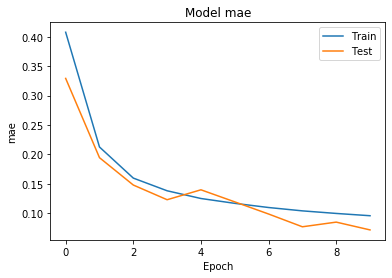

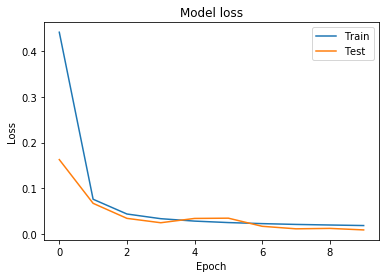

In [95]:
# Plot training & validation accuracy values
plt.plot(history.history[modified_acc.__name__])
plt.plot(history.history['val_'+ modified_acc.__name__])
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.savefig(workDir + 'model_mae.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.savefig(workDir + 'model_loss.png')
plt.show()